In [1]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

# ATMO 5331 - Homework 3 - Fall 2023
## Due Monday 9 Oct, 2023, 11:59 pm

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

For this assignment you may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB</span>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

For this assignment, download some [sample Ka data](http://www.atmo.ttu.edu/bruning/5331/Ka2140614021408.RAWPXA9.nc). These data were converted directly from the raw format collected by the radar (Sigmet) to the [NetCDF CF/Radial standard](http://ncar.github.io/CfRadial/). No further processing has been applied. You do not have to include this file in your repository.

In the file, the radar variables (such as reflectivity) are stored in arrays with dimension `(time, range)`. At each time, a single ray of data is collected, which extends along range. There is also a `sweep` dimension that corresponds to a few different variables. These variables mark the start and the end of each radar scan. Let's look at that structure:

In [3]:
# Read netcdf file
d = xr.open_dataset('Ka2140614021408.RAWPXA9.nc')
d

<xarray.Dataset>
Dimensions:                    (time: 2938, range: 1666, sweep: 5)
Coordinates:
  * time                       (time) datetime64[ns] 2014-06-14T02:14:19 ... ...
  * range                      (range) float32 0.0 15.0 ... 2.496e+04 2.498e+04
    azimuth                    (time) float32 ...
    elevation                  (time) float32 ...
Dimensions without coordinates: sweep
Data variables: (12/25)
    total_power                (time, range) float32 ...
    reflectivity               (time, range) float32 ...
    velocity                   (time, range) float32 ...
    spectrum_width             (time, range) float32 ...
    normalized_coherent_power  (time, range) float32 ...
    sweep_number               (sweep) int32 ...
    ...                         ...
    longitude                  float64 ...
    altitude                   float64 ...
    time_coverage_start        |S32 ...
    time_coverage_end          |S32 ...
    time_reference             |S32 ...
    volume_number              int32 ...
Attributes: (12/15)
    Conventions:             CF/Radial instrument_parameters
    version:                 1.3
    title:                   
    institution:             
    references:              
    source:                  
    ...                      ...
    sigmet_task_name:        TRANS_RHI   
    sigmet_extended_header:  false
    time_ordered:            none
    rays_missing:            67
    field_names:             total_power, reflectivity, velocity, spectrum_wi...
    history:

In [4]:
'''
print(d.sweep_mode)
print(d.sweep_start_ray_index)
print(d.sweep_end_ray_index)

az = d.azimuth[:]
el = d.elevation[:]
t = d.time[:]
fig, axs = plt.subplots(3,1, squeeze=False, figsize=(10,10))

axs[0,0].plot(t,el, '.k')
axs[0,0].set_ylabel('Elevation angle (deg)')
axs[0,0].set_xlabel('Time (UTC)')
axs[1,0].plot(t,az, '.k')
axs[1,0].set_ylabel('Azimuth angle (deg)')
axs[1,0].set_xlabel('Time (UTC)')
axs[2,0].plot(t, np.arange(t.shape[0]), '.k')
axs[2,0].set_ylabel('Index along time dimension')
axs[2,0].set_xlabel('Time (UTC)')
for sw_start, sw_end in zip(d.sweep_start_ray_index, d.sweep_end_ray_index):
    axs[0,0].plot(t[sw_start], el[sw_start], marker='o', color='g')
    axs[0,0].plot(t[sw_end], el[sw_end], marker='o',color='r')
    axs[2,0].plot(t[sw_start], sw_start, marker='o', color='g')
    axs[2,0].plot(t[sw_end], sw_end, marker='o',color='r')
'''

"\nprint(d.sweep_mode)\nprint(d.sweep_start_ray_index)\nprint(d.sweep_end_ray_index)\n\naz = d.azimuth[:]\nel = d.elevation[:]\nt = d.time[:]\nfig, axs = plt.subplots(3,1, squeeze=False, figsize=(10,10))\n\naxs[0,0].plot(t,el, '.k')\naxs[0,0].set_ylabel('Elevation angle (deg)')\naxs[0,0].set_xlabel('Time (UTC)')\naxs[1,0].plot(t,az, '.k')\naxs[1,0].set_ylabel('Azimuth angle (deg)')\naxs[1,0].set_xlabel('Time (UTC)')\naxs[2,0].plot(t, np.arange(t.shape[0]), '.k')\naxs[2,0].set_ylabel('Index along time dimension')\naxs[2,0].set_xlabel('Time (UTC)')\nfor sw_start, sw_end in zip(d.sweep_start_ray_index, d.sweep_end_ray_index):\n    axs[0,0].plot(t[sw_start], el[sw_start], marker='o', color='g')\n    axs[0,0].plot(t[sw_end], el[sw_end], marker='o',color='r')\n    axs[2,0].plot(t[sw_start], sw_start, marker='o', color='g')\n    axs[2,0].plot(t[sw_end], sw_end, marker='o',color='r')\n"

The green dots mark the start of a sweep according to `sweep_start_ray_index`, and red marks the end according to `sweep_end_ray_index`. We observe that:

0. the scans are in [RHI](http://ww2010.atmos.uiuc.edu/(Gh)/guides/rs/rad/basics/cnmod.rxml) mode, per the scan_mode variable.
1. the data have time precision of 1 s
2. the data are not stored in time order.
3. the data are stored in the file in order of increasing elevation angle, not increasing time.
4. azimuth angle is constant.

For the rest of this assignment, let's work with the second of the five scans, where time and elevation both increase with index along the time dimension. Reuse this variable instead of hard-coding a scan number in later code.

**1.** Let's start by preparing the coordinates needed to plot a scan. Write a function that takes a radar dataset and scan index, and returns  2D arrays of ranges, azimuths, and elevations that correspond to the edges of each radar sample (a.k.a., each gate). Your function should return three separate 2D variables, as you see in the sample function call below. `coords_2d` should call another helper function, `spherical_coord_edges(d, scan_idx)` that returns the 1D coordinates along each coordinate direction for that sweep. I found it helpful to visualize how the coordinates were distributed in 2D a quick, unlableled plot of each coordinate: `plt.imshow(r)`.

Also print out the shapes of r, az, and el.

In [5]:
#r, az, el = coords_2d(d, scan_idx)

###  Obtain 2D for Range, Azimuth, and Elevation

In [6]:
scan_idx = 1

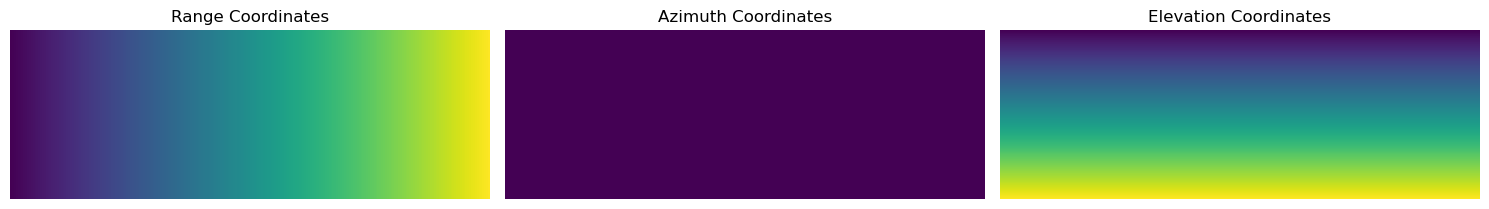

Shape of r: (586, 1667)
Shape of az: (586, 1667)
Shape of el: (586, 1667)


In [7]:
# Your centers_to_edges_1d function
def spherical_coord_edges(d, scan_idx):
    start_idx = d.sweep_start_ray_index[scan_idx].values.item()
    end_idx = d.sweep_end_ray_index[scan_idx].values.item()

    def get_edges(x):     # Eric's `centers_to_edges_1d` conversion method
        nx_edges = x.shape[0] + 1
        xe = np.zeros(nx_edges)
        xe[1:-1] = (x[1:] + x[:-1]) / 2.0
        xe[0] = x[0] - (x[1] - x[0]) / 2.0
        xe[-1] = x[-1] + (x[-1] - x[-2]) / 2.0
        return xe

    r_edges = get_edges(d['range'].values)
    az_edges = get_edges(d['azimuth'][start_idx:end_idx].values)
    el_edges = get_edges(d['elevation'][start_idx:end_idx].values)
     
    return r_edges, az_edges, el_edges


def coords_2d(d, scan_idx):
    # Get 1D coordinates using the helper function
    r_1d, az_1d, el_1d = spherical_coord_edges(d, scan_idx)

    # Convert the 1D coordinates to 2D using numpy's meshgrid
    r_2d, az_2d = np.meshgrid(r_1d, az_1d)
    r_2d, el_2d = np.meshgrid(r_1d, el_1d)

    return r_2d, az_2d, el_2d


# Using the function:
r, az, el = coords_2d(d, scan_idx)


# Visualizing the coordinates
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting Range Coordinates
axes[0].imshow(r)
axes[0].set_title('Range Coordinates')
axes[0].axis('off')  # Turn off axis for better visualization

# Plotting Azimuth Coordinates
axes[1].imshow(az)
axes[1].set_title('Azimuth Coordinates')
axes[1].axis('off')  # Turn off axis for better visualization

# Plotting Elevation Coordinates
axes[2].imshow(el)
axes[2].set_title('Elevation Coordinates')
axes[2].axis('off')  # Turn off axis for better visualization

plt.tight_layout()  # Adjusts the plots to fit better
plt.show()


# Printing the shapes
print("Shape of r:", r.shape)
print("Shape of az:", az.shape)
print("Shape of el:", el.shape)

**2.** Make a 4-panel plot of reflectivity, velocity, spectrum width, and normalized coherent power. Use `coordinateSystems.RadarCoordinateSystem` together with a tangent plane system to plot in altitude above vs. range along a tangent plane. The tangent plane should be centered at the location of radar. You will need to definte a new variable that gives range along the tangent plane.

Note that if you find that the coordinate transformations fail to preserve the shape of your input coordinate arrays, you can fix it with `X.shape = r.shape`, where `X` has been transformed from `r`.

In [8]:
# Recalling start and end indexes
start_idx = d.sweep_start_ray_index[scan_idx].values.item()
end_idx = d.sweep_end_ray_index[scan_idx].values.item()

# Variables of interest
ref = d.reflectivity[:][start_idx:end_idx].values
vel = d.velocity[:][start_idx:end_idx].values
sw = d.spectrum_width[:][start_idx:end_idx].values
ncp = d.normalized_coherent_power[:][start_idx:end_idx].values

print(ref.shape)
print(vel.shape)
print(sw.shape)
print(ncp.shape)


(585, 1666)
(585, 1666)
(585, 1666)
(585, 1666)


In [9]:
# Import Radar & Tangent Coordinate Systems class from the coords module.
from coords import RadarCoordinateSystem, TangentPlaneCartesianSystem

# Retrieving the latitude, longitude, and altitude values from the data
lat = d.latitude
lon = d.longitude
alt = d.altitude

# Creating an instance of the RadarCoordinateSystem class with provided parameters
rad_cs = RadarCoordinateSystem(lat, lon, alt, datum='WGS84', ellps='WGS84', effectiveRadiusMultiplier=4./3.)

# Converting radar spherical coordinates to Earth-centered, Earth-fixed (ECEF) coordinates
lon_ecef, lat_ecef, alt_ecef = rad_cs.toECEF(r, az, el)

# Creating an instance of the TangentPlaneCartesianSystem class for the given location
tp_cs = TangentPlaneCartesianSystem(lat, lon, alt)

# Converting ECEF coordinates to tangent plane cartesian coordinates
X, Y, Z = tp_cs.fromECEF(lon_ecef, lat_ecef, alt_ecef)

# Reshaping the X, Y, and Z arrays to match the shapes of the radar data arrays
X.shape = r.shape
Y.shape = az.shape
Z.shape = el.shape


#### Generate a 4-panel plot with altitude vs. range for each of the specified radar variables

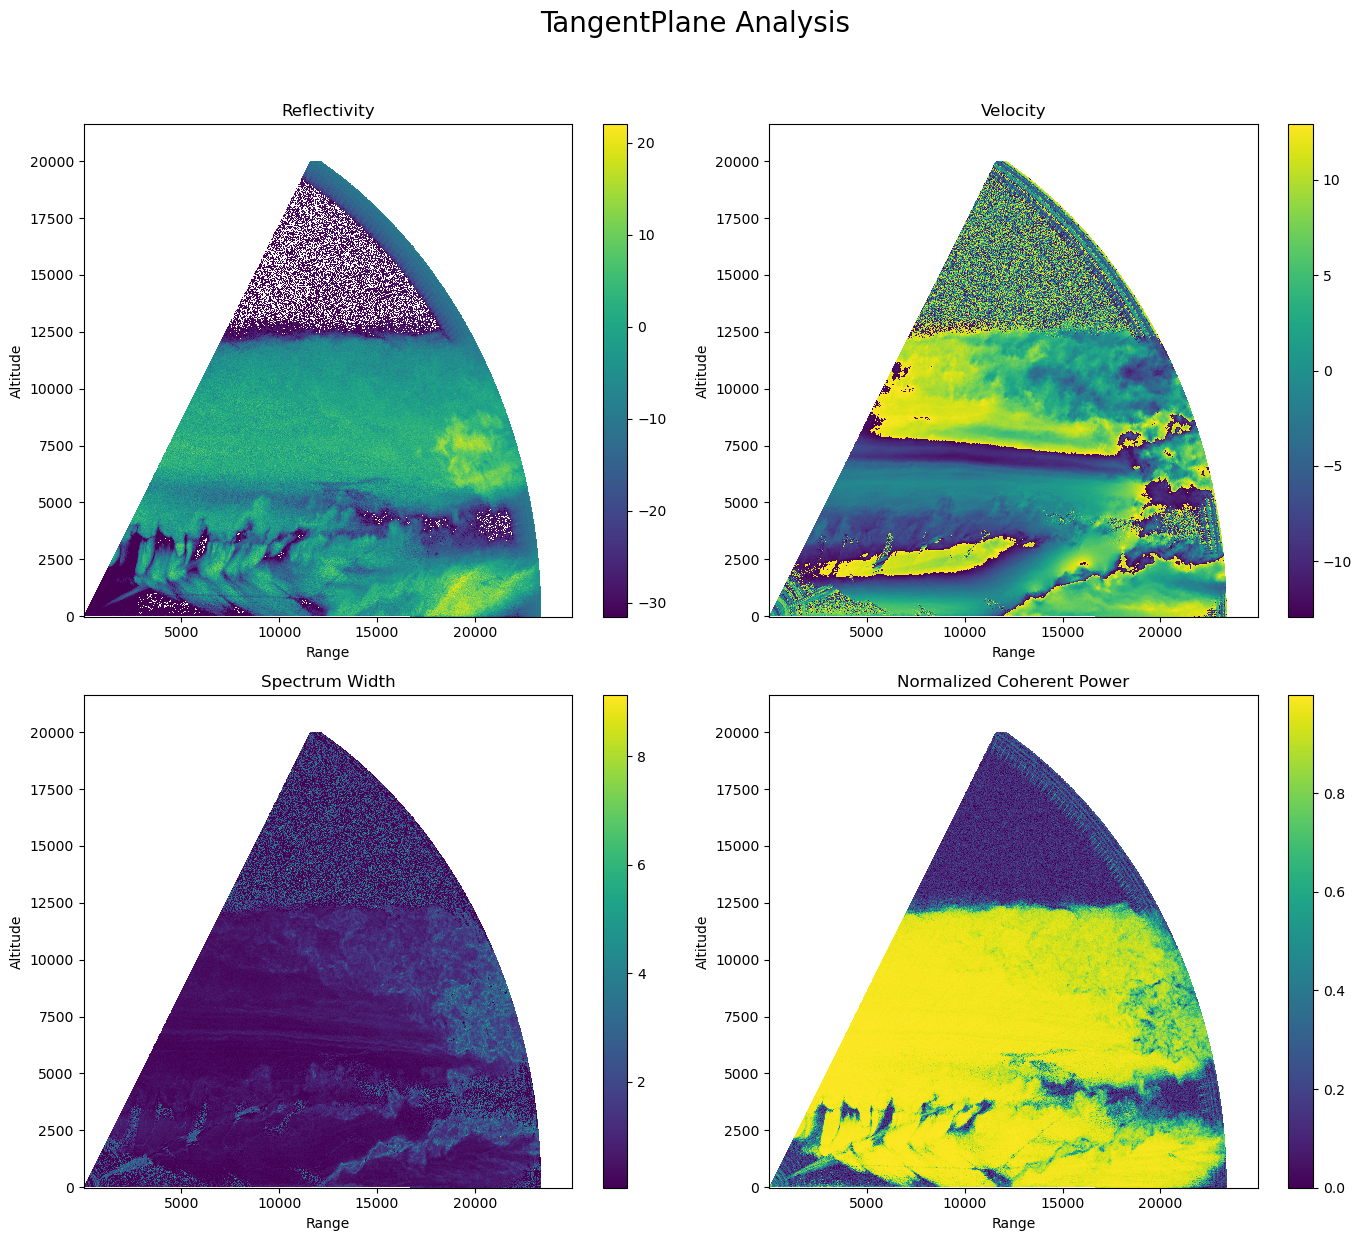

In [10]:
# Calculate the range along the tangent plane.
range_along_tangent = np.sqrt(X**2 + Y**2)

# Create the 4-panel plot
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Main Title for the Entire Figure
fig.suptitle('TangentPlane Analysis', fontsize=20, y=1.03)

# Reflectivity
c1 = axs[0, 0].pcolormesh(range_along_tangent, Z, ref, shading='auto')
axs[0, 0].set_title('Reflectivity')
axs[0, 0].set_xlabel('Range')
axs[0, 0].set_ylabel('Altitude')
fig.colorbar(c1, ax=axs[0, 0])

# Velocity
c2 = axs[0, 1].pcolormesh(range_along_tangent, Z, vel, shading='auto')
axs[0, 1].set_title('Velocity')
axs[0, 1].set_xlabel('Range')
axs[0, 1].set_ylabel('Altitude')
fig.colorbar(c2, ax=axs[0, 1])

# Spectrum Width
c3 = axs[1, 0].pcolormesh(range_along_tangent, Z, sw, shading='auto')
axs[1, 0].set_title('Spectrum Width')
axs[1, 0].set_xlabel('Range')
axs[1, 0].set_ylabel('Altitude')
fig.colorbar(c3, ax=axs[1, 0])

# Normalized Coherent Power
c4 = axs[1, 1].pcolormesh(range_along_tangent, Z, ncp, shading='auto')
axs[1, 1].set_title('Normalized Coherent Power')
axs[1, 1].set_xlabel('Range')
axs[1, 1].set_ylabel('Altitude')
fig.colorbar(c4, ax=axs[1, 1])

# Adjust layout
plt.tight_layout()
plt.show()


**3.** Repeat the plot for question 2, but for an aziuthal equidistant map projection centered at the radar location.

As above, you will to definte a new variable that gives a horizontal distance (a sort of "range") using the coordinates returned from the map projection. This can be calculated in one line of code.

How does this plot compare to the plot defined in tangent plane coordinates?

In [11]:
'''
#Where is the radar? What is its gate spacing?
print(d.latitude)
print(d.longitude)
print(d.range[1]-d.range[0])

'''

'\n#Where is the radar? What is its gate spacing?\nprint(d.latitude)\nprint(d.longitude)\nprint(d.range[1]-d.range[0])\n\n'

In [12]:
# Import the MapProjection class from the coords module.
from coords import MapProjection

# Creating an instance of the MapProjection class with provided parameters
mp_aeqd = MapProjection(projection='aeqd', ctrLat=lat, ctrLon=lon, ellipse='WGS84', datum='WGS84')

# Transform the 3D coordinates from Earth-Centered Earth-Fixed (ECEF) format to the aeqd projection.
X_aeqd, Y_aeqd, Z_aeqd = mp_aeqd.fromECEF(lon_ecef, lat_ecef, alt_ecef)

# Reshape the transformed coordinates to match the shapes of some pre-existing arrays (r, az, el).
X_aeqd.shape = r.shape
Y_aeqd.shape = az.shape
Z_aeqd.shape = el.shape

print("First index of X:", X[0])
print("First index of X_aeqd:", X_aeqd[0])


First index of X: [-7.38605785e+00  7.38605785e+00  2.21581735e+01 ...  2.45734136e+04
  2.45881858e+04  2.46029579e+04]
First index of X_aeqd: [-5.84565258e+00  5.84565294e+00  1.75369599e+01 ...  1.94503952e+04
  1.94620888e+04  1.94737824e+04]


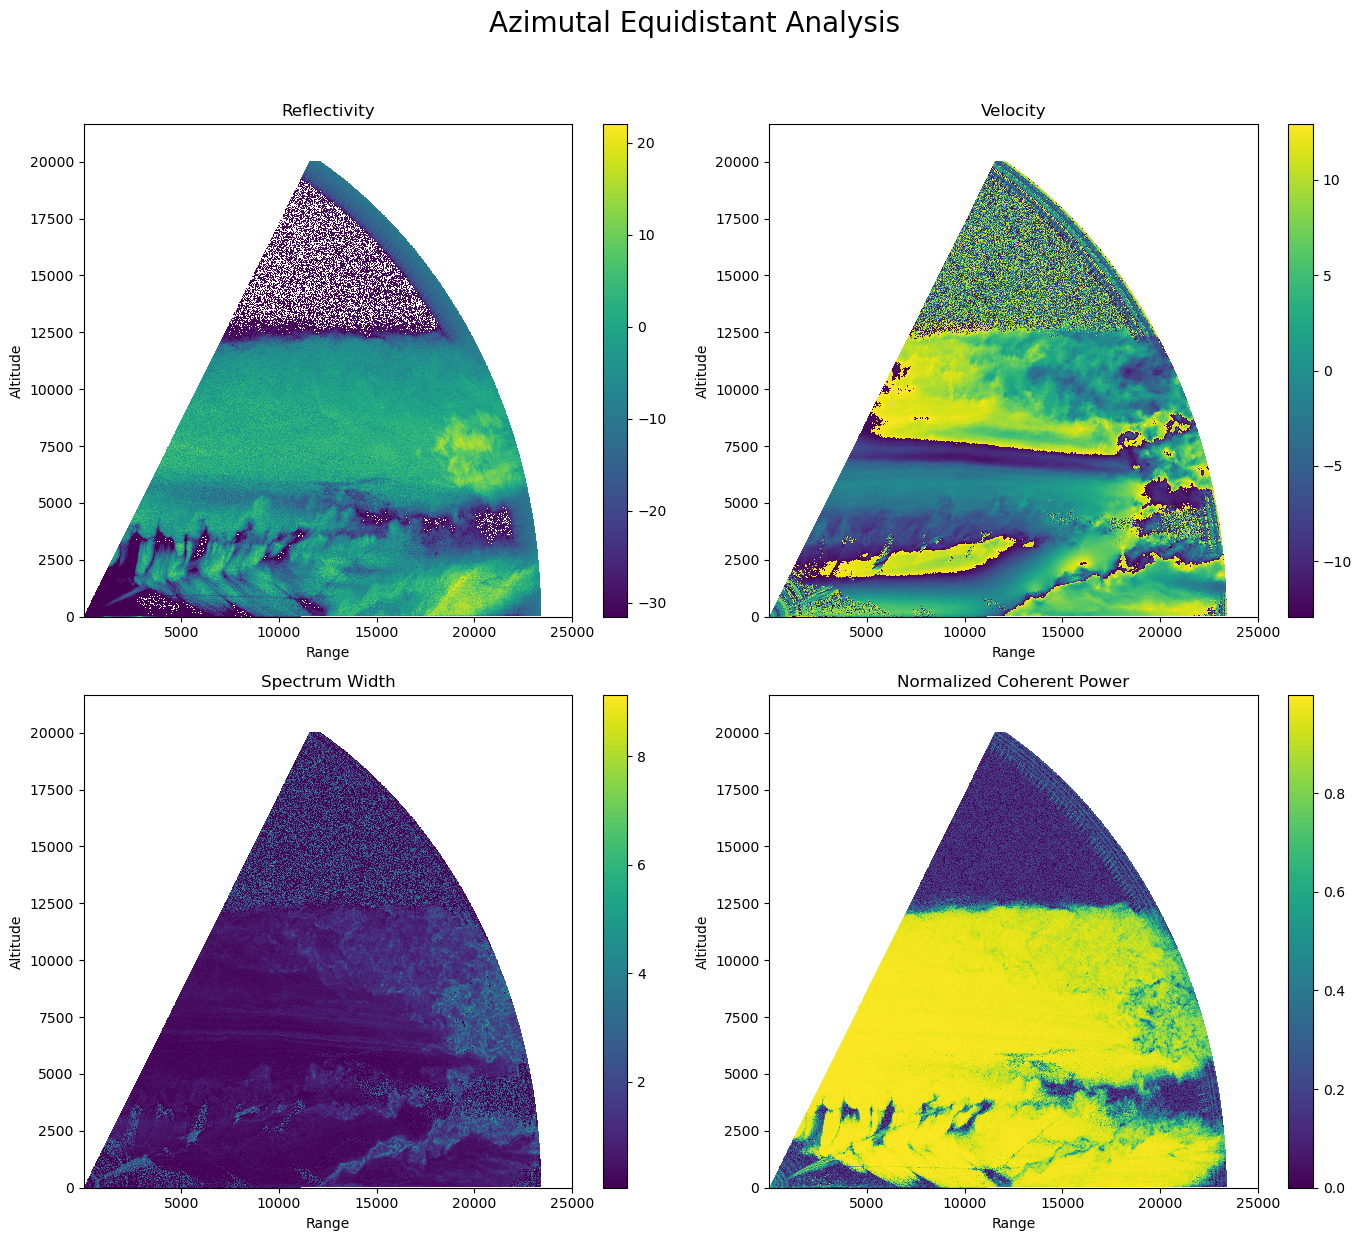

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the horizontal distance (range) in the aeqd projection.
range_along_aeqd = np.sqrt(X_aeqd**2 + Y_aeqd**2)

# Create the 4-panel plot
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Main Title for the Entire Figure
fig.suptitle('Azimutal Equidistant Analysis', fontsize=20, y=1.03)

# Reflectivity
c1 = axs[0, 0].pcolormesh(range_along_aeqd, Z_aeqd, ref, shading='auto')
axs[0, 0].set_title('Reflectivity')
axs[0, 0].set_xlabel('Range')
axs[0, 0].set_ylabel('Altitude')
fig.colorbar(c1, ax=axs[0, 0])

# Velocity
c2 = axs[0, 1].pcolormesh(range_along_aeqd, Z_aeqd, vel, shading='auto')
axs[0, 1].set_title('Velocity')
axs[0, 1].set_xlabel('Range')
axs[0, 1].set_ylabel('Altitude')
fig.colorbar(c2, ax=axs[0, 1])

# Spectrum Width
c3 = axs[1, 0].pcolormesh(range_along_aeqd, Z_aeqd, sw, shading='auto')
axs[1, 0].set_title('Spectrum Width')
axs[1, 0].set_xlabel('Range')
axs[1, 0].set_ylabel('Altitude')
fig.colorbar(c3, ax=axs[1, 0])

# Normalized Coherent Power
c4 = axs[1, 1].pcolormesh(range_along_aeqd, Z_aeqd, ncp, shading='auto')
axs[1, 1].set_title('Normalized Coherent Power')
axs[1, 1].set_xlabel('Range')
axs[1, 1].set_ylabel('Altitude')
fig.colorbar(c4, ax=axs[1, 1])

# Adjust layout
plt.tight_layout()
plt.show()


#### Comparison of the tangent plane and azimuthal images:

#### Data Density and Resolution:
- In both sets of plots, it appears that there is an evident denser cluster of data near the center, which is expected in radar plots. However, the azimuthal images show a more pronounced delineation between areas of dense data and those with sparse data, especially visible in the Reflectivity and Velocity plots.

#### Visualization of Features:
- The features in `the tangent plane images` appear stretched, especially as you move further away from the center. This is more evident in the Velocity and Normalized Coherent Power plots.

- In contrast, `the azimuthal images` present a more uniform view, and features appear less distorted. The continuity and patterns in the data, especially in the Velocity plot, appear more natural in the azimuthal projection.

#### Edges and Boundaries:
- The boundaries of `the tangent plane images` seem to be more abrupt, whereas `the azimuthal images` present a more gradual transition, especially evident in the Reflectivity plot.

#### Conclusion:
Generally, it appears the tangent plane offers a flattened view, which can sometimes introduce distortions, especially at the edges. Visually, the azimuthal projection appears to provide a clearer and more intuitive representation.

To set the stage for the next two assignments, let's say we want to oversample the 15 m range gates to a 5 m carteisian grid in the domain 9.0…9.5 km range and 2.9…3.4 km altitude. Once again, we will use the distance above and the range along the tangent plane.

**4.** Create 2D arrays giving the corresponding center locations for each desired analysis location. Start with 1D grid box edges spanning the range above.

<span class="ecb">Looks like you have one more value than needed in each direction, but you do have the correct centers. Note that the manual loops in [ ] (list comprehensions) can be replaced with `np.arange`, and the center calcualaion with `(x[1:] + x[:-1])/2.0`. That's advice; nice solution!</span>

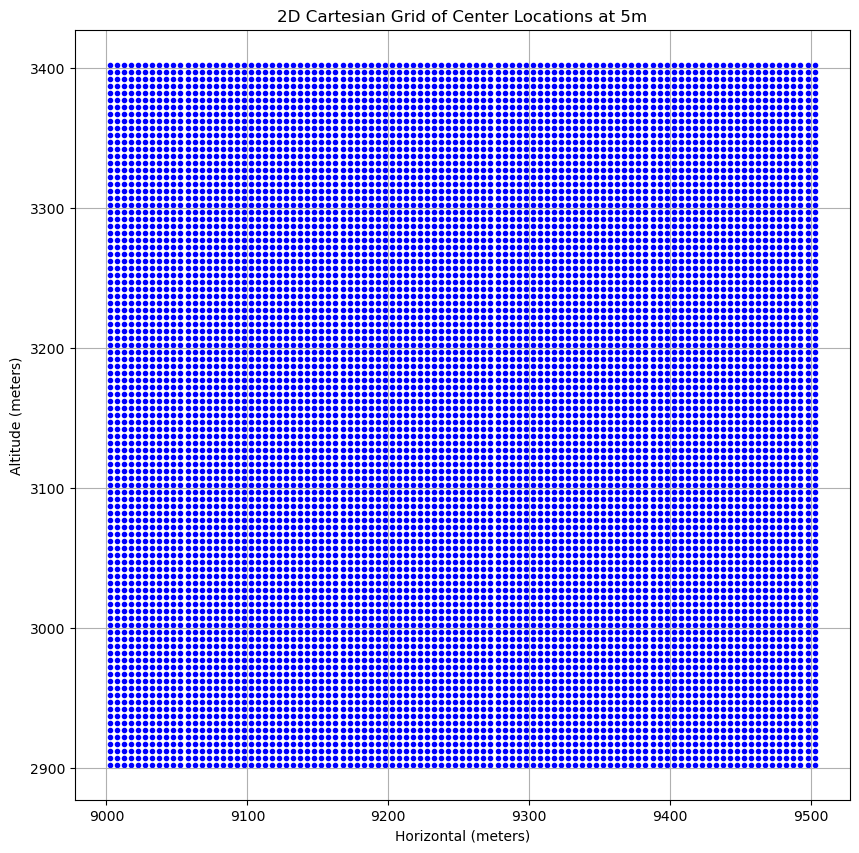

In [14]:
# Starting and ending points for both dimensions (converted to meters)
x_start, x_end = 9000, 9500  # in meters
y_start, y_end = 2900, 3400  # in meters

# Spacing in meters
fine_spacing = 5  # 5 meters

# Compute the 1D grid box edges in meters
x_edges = [x_start + i*fine_spacing for i in range(int((x_end-x_start)/fine_spacing) + 2)]
y_edges = [y_start + i*fine_spacing for i in range(int((y_end-y_start)/fine_spacing) + 2)]

# Determine the center locations between each pair of consecutive edges in meters
x_centers = [(x_edges[i] + x_edges[i+1])/2 for i in range(len(x_edges)-1)]
y_centers = [(y_edges[i] + y_edges[i+1])/2 for i in range(len(y_edges)-1)]

# Use meshgrid to create 2D arrays of center locations
X_centers_grid, Y_centers_grid = np.meshgrid(x_centers, y_centers)

# Plotting the 2D grid of center locations in meters
plt.figure(figsize=(10, 10))
plt.scatter(X_centers_grid, Y_centers_grid, marker='.', color='blue')
plt.title('2D Cartesian Grid of Center Locations at 5m')
plt.xlabel('Horizontal (meters)')
plt.ylabel('Altitude (meters)')
plt.grid(True)
plt.show()


**5.** For the next question, we will interpolate in three ways:
- nearest neighbor
- linear
- the traditional meteorological "Barnes" analysis (which is really a Gaussian blur fliter). 

To do so, we will use MetPy's built-in interpolators. It wraps SciPy's built-in nearest and linear interpolation methods, and adds Barnes, natural neighbor, and other interpolators. 

You will probably need to install metpy with `conda install -c conda-forge metpy`.

Once you have installed MetPy, use its `interpolate_to_points` function. Note that it takes three arguments, and those arguments require that you use `np.vstack` to rearrange the locations and data into the correct shape.

So that the Barnes analysis doesn't take forever, you will want to subset the data to only those locations that overlap with the analysis grid.

### Interpolation methods

In [15]:
#from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator, griddata
#from metpy.units import units
#from metpy.interpolate import interpolate_to_points
#interpolate_to_points?

In [16]:
# Recalling start and end indexes
start_idx = d.sweep_start_ray_index[scan_idx].values.item()
end_idx = d.sweep_end_ray_index[scan_idx].values.item()

# Recalling Variables of interest
ref = d.reflectivity[:][start_idx:end_idx].values
#vel = d.velocity[:][start_idx:end_idx].values
#sw = d.spectrum_width[:][start_idx:end_idx].values
#ncp = d.normalized_coherent_power[:][start_idx:end_idx].values

print(ref.shape)
#print(spec_wd.shape)
#print(vel.shape)
#print(n_cop.shape)


(585, 1666)


### Variable of interest: `Reflectivity`

In [17]:
# Import useful intepolation functions from metpy library
from metpy.interpolate import interpolate_to_points

# Variables of interest for reflectivity
ref = d.reflectivity[:][start_idx:end_idx].values

# Extracting elevation and range for RHI scan mode
elev_ref = d.elevation[start_idx:end_idx].values
range_ref = d.range.values

# Convert to Cartesian coordinates for RHI
z_ref = range_ref * np.sin(np.deg2rad(elev_ref[:, np.newaxis]))  # Vertical height (reflectivity height)
x_ref = range_ref * np.cos(np.deg2rad(elev_ref[:, np.newaxis]))  # Horizontal distance (reflectivity distance)

# Stack the x and z data locations
data_points_ref = np.vstack((x_ref.ravel(), z_ref.ravel())).T
data_values_ref = ref.ravel()

# Create the analysis grid points
analysis_points_ref = np.vstack((X_centers_grid.ravel(), Y_centers_grid.ravel())).T

# Subset the data to speed up Barnes analysis
mask_ref = ((data_points_ref[:, 0] >= x_start) & (data_points_ref[:, 0] <= x_end) &
            (data_points_ref[:, 1] >= y_start) & (data_points_ref[:, 1] <= y_end))

subset_points_ref = data_points_ref[mask_ref]
subset_values_ref = data_values_ref[mask_ref]

# Nearest Neighbor Interpolation
nearest_interp_ref = interpolate_to_points(subset_points_ref, subset_values_ref, analysis_points_ref, interp_type='nearest').reshape(X_centers_grid.shape)

# Linear Interpolation
linear_interp_ref = interpolate_to_points(subset_points_ref, subset_values_ref, analysis_points_ref, interp_type='linear').reshape(X_centers_grid.shape)

# Barnes Analysis (Gaussian blur)
barnes_interp_ref = interpolate_to_points(subset_points_ref, subset_values_ref, analysis_points_ref, interp_type='barnes').reshape(X_centers_grid.shape)


### Variable of interest: `Velocity`

In [18]:
# Variables of interest for velocity
vel = d.velocity[:][start_idx:end_idx].values

# Convert to Cartesian coordinates for RHI
z_vel = range_ref * np.sin(np.deg2rad(elev_ref[:, np.newaxis]))  # Vertical height (velocity height)
x_vel = range_ref * np.cos(np.deg2rad(elev_ref[:, np.newaxis]))  # Horizontal distance (velocity distance)

# Stack the x and z data locations
data_points_vel = np.vstack((x_vel.ravel(), z_vel.ravel())).T
data_values_vel = vel.ravel()

# Subset the data for velocity to speed up Barnes analysis
mask_vel = ((data_points_vel[:, 0] >= x_start) & (data_points_vel[:, 0] <= x_end) &
            (data_points_vel[:, 1] >= y_start) & (data_points_vel[:, 1] <= y_end))

subset_points_vel = data_points_vel[mask_vel]
subset_values_vel = data_values_vel[mask_vel]

# Nearest Neighbor Interpolation for velocity
nearest_interp_vel = interpolate_to_points(subset_points_vel, subset_values_vel, analysis_points_ref, interp_type='nearest').reshape(X_centers_grid.shape)

# Linear Interpolation for velocity
linear_interp_vel = interpolate_to_points(subset_points_vel, subset_values_vel, analysis_points_ref, interp_type='linear').reshape(X_centers_grid.shape)

# Barnes Analysis (Gaussian blur) for velocity
barnes_interp_vel = interpolate_to_points(subset_points_vel, subset_values_vel, analysis_points_ref, interp_type='barnes').reshape(X_centers_grid.shape)


### Variable of interest: `Spectrum Width`

In [19]:
# Variables of interest for spectrum width
sw = d.spectrum_width[:][start_idx:end_idx].values

# Convert to Cartesian coordinates for RHI
z_sw = range_ref * np.sin(np.deg2rad(elev_ref[:, np.newaxis]))  # Vertical height (spectrum width height)
x_sw = range_ref * np.cos(np.deg2rad(elev_ref[:, np.newaxis]))  # Horizontal distance (spectrum width distance)

# Stack the x and z data locations
data_points_sw = np.vstack((x_sw.ravel(), z_sw.ravel())).T
data_values_sw = sw.ravel()

# Subset the data for spectrum width to speed up Barnes analysis
mask_sw = ((data_points_sw[:, 0] >= x_start) & (data_points_sw[:, 0] <= x_end) &
           (data_points_sw[:, 1] >= y_start) & (data_points_sw[:, 1] <= y_end))

subset_points_sw = data_points_sw[mask_sw]
subset_values_sw = data_values_sw[mask_sw]

# Nearest Neighbor Interpolation for spectrum width
nearest_interp_sw = interpolate_to_points(subset_points_sw, subset_values_sw, analysis_points_ref, interp_type='nearest').reshape(X_centers_grid.shape)

# Linear Interpolation for spectrum width
linear_interp_sw = interpolate_to_points(subset_points_sw, subset_values_sw, analysis_points_ref, interp_type='linear').reshape(X_centers_grid.shape)

# Barnes Analysis (Gaussian blur) for spectrum width
barnes_interp_sw = interpolate_to_points(subset_points_sw, subset_values_sw, analysis_points_ref, interp_type='barnes').reshape(X_centers_grid.shape)


### Variable of interest: `Normalized Coherent Power`

In [20]:
# Variables of interest for normalized coherent power
ncp = d.normalized_coherent_power[:][start_idx:end_idx].values

# Convert to Cartesian coordinates for RHI
z_ncp = range_ref * np.sin(np.deg2rad(elev_ref[:, np.newaxis]))  # Vertical height (ncp height)
x_ncp = range_ref * np.cos(np.deg2rad(elev_ref[:, np.newaxis]))  # Horizontal distance (ncp distance)

# Stack the x and z data locations
data_points_ncp = np.vstack((x_ncp.ravel(), z_ncp.ravel())).T
data_values_ncp = ncp.ravel()

# Subset the data for ncp to speed up Barnes analysis
mask_ncp = ((data_points_ncp[:, 0] >= x_start) & (data_points_ncp[:, 0] <= x_end) &
            (data_points_ncp[:, 1] >= y_start) & (data_points_ncp[:, 1] <= y_end))

subset_points_ncp = data_points_ncp[mask_ncp]
subset_values_ncp = data_values_ncp[mask_ncp]

# Nearest Neighbor Interpolation for ncp
nearest_interp_ncp = interpolate_to_points(subset_points_ncp, subset_values_ncp, analysis_points_ref, interp_type='nearest').reshape(X_centers_grid.shape)

# Linear Interpolation for ncp
linear_interp_ncp = interpolate_to_points(subset_points_ncp, subset_values_ncp, analysis_points_ref, interp_type='linear').reshape(X_centers_grid.shape)

# Barnes Analysis (Gaussian blur) for ncp
barnes_interp_ncp = interpolate_to_points(subset_points_ncp, subset_values_ncp, analysis_points_ref, interp_type='barnes').reshape(X_centers_grid.shape)


**6.** Make a plot of the original data and the three interpolation methods. Compared to the original data, what do the three interpolation methods do to the data? Think about what you would regard as desirable properties of an analysis.

### Interpolation plots

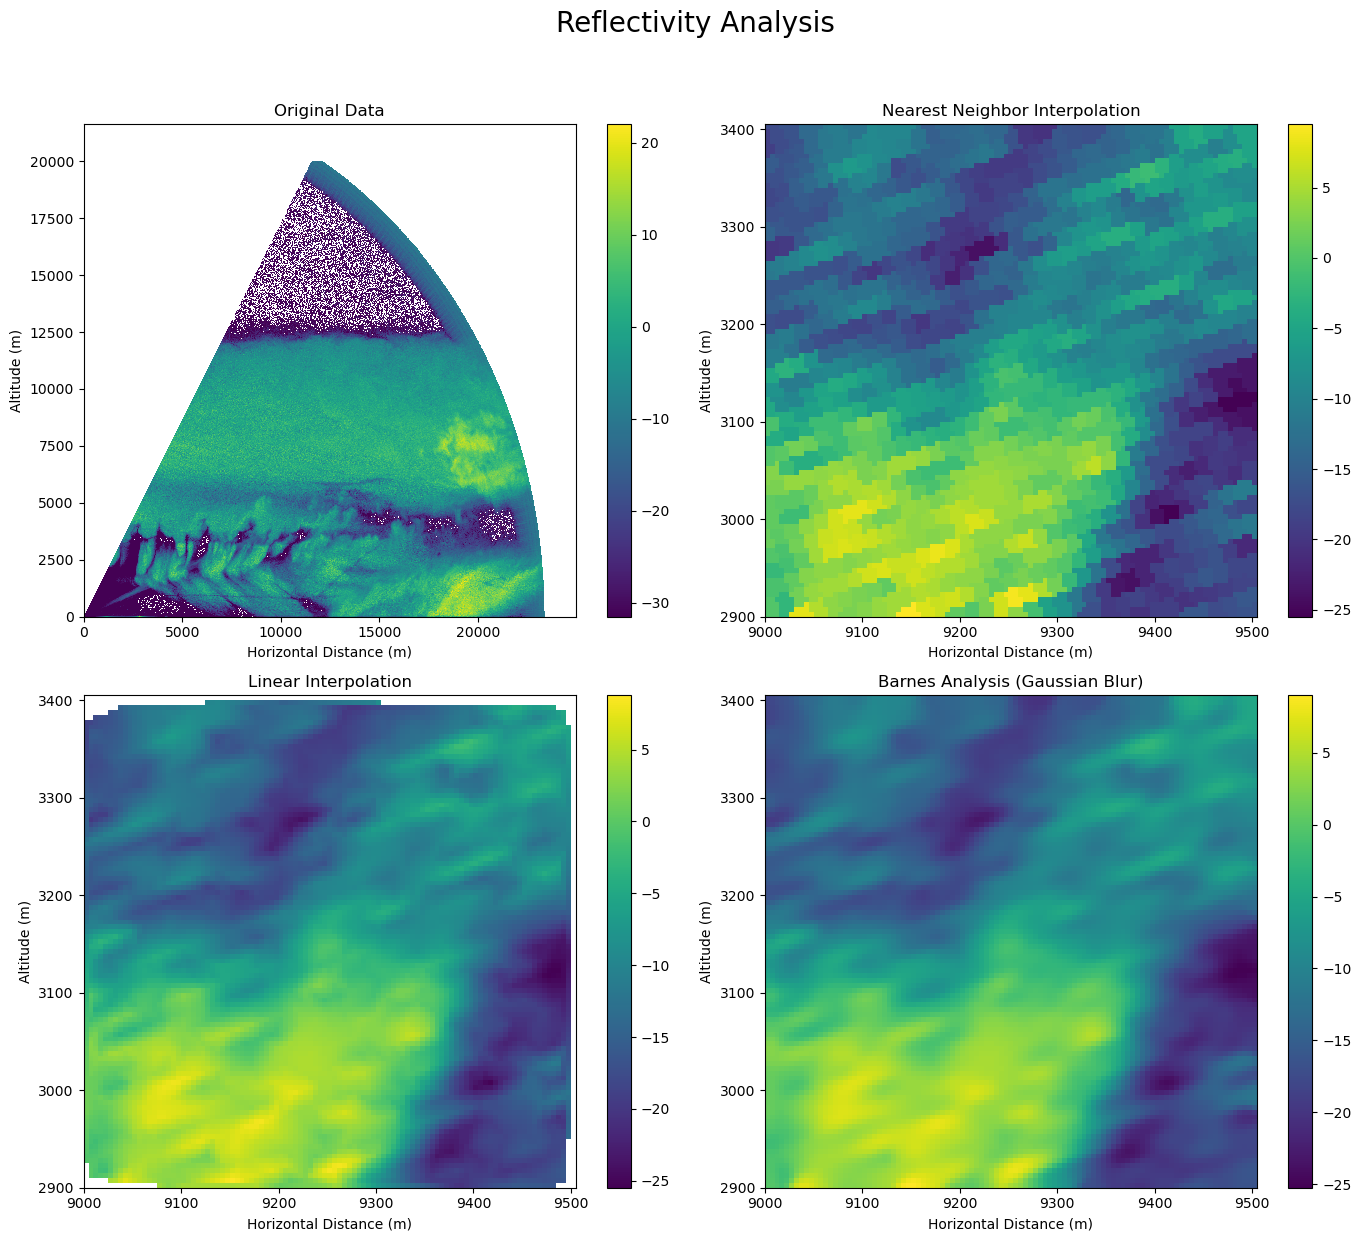

In [21]:
# 1.) Interpolation for Reflectivity

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

# Main Title for the Entire Figure
fig.suptitle('Reflectivity Analysis', fontsize=20, y=1.03)

# Plot Original Data
c1 = axes[0, 0].pcolormesh(x_ref, z_ref, ref, shading='auto', cmap='viridis')
axes[0, 0].set_title('Original Data')
axes[0, 0].set_xlabel('Horizontal Distance (m)')
axes[0, 0].set_ylabel('Altitude (m)')
fig.colorbar(c1, ax=axes[0, 0])

# Plot Nearest Neighbor Interpolation
c2 = axes[0, 1].pcolormesh(X_centers_grid, Y_centers_grid, nearest_interp_ref, shading='auto', cmap='viridis')
axes[0, 1].set_title('Nearest Neighbor Interpolation')
axes[0, 1].set_xlabel('Horizontal Distance (m)')
axes[0, 1].set_ylabel('Altitude (m)')
fig.colorbar(c2, ax=axes[0, 1])

# Plot Linear Interpolation
c3 = axes[1, 0].pcolormesh(X_centers_grid, Y_centers_grid, linear_interp_ref, shading='auto', cmap='viridis')
axes[1, 0].set_title('Linear Interpolation')
axes[1, 0].set_xlabel('Horizontal Distance (m)')
axes[1, 0].set_ylabel('Altitude (m)')
fig.colorbar(c3, ax=axes[1, 0])

# Plot Barnes Interpolation
c4 = axes[1, 1].pcolormesh(X_centers_grid, Y_centers_grid, barnes_interp_ref, shading='auto', cmap='viridis')
axes[1, 1].set_title('Barnes Analysis (Gaussian Blur)')
axes[1, 1].set_xlabel('Horizontal Distance (m)')
axes[1, 1].set_ylabel('Altitude (m)')
fig.colorbar(c4, ax=axes[1, 1])

# Adjust layout for clarity
plt.tight_layout()
plt.show()

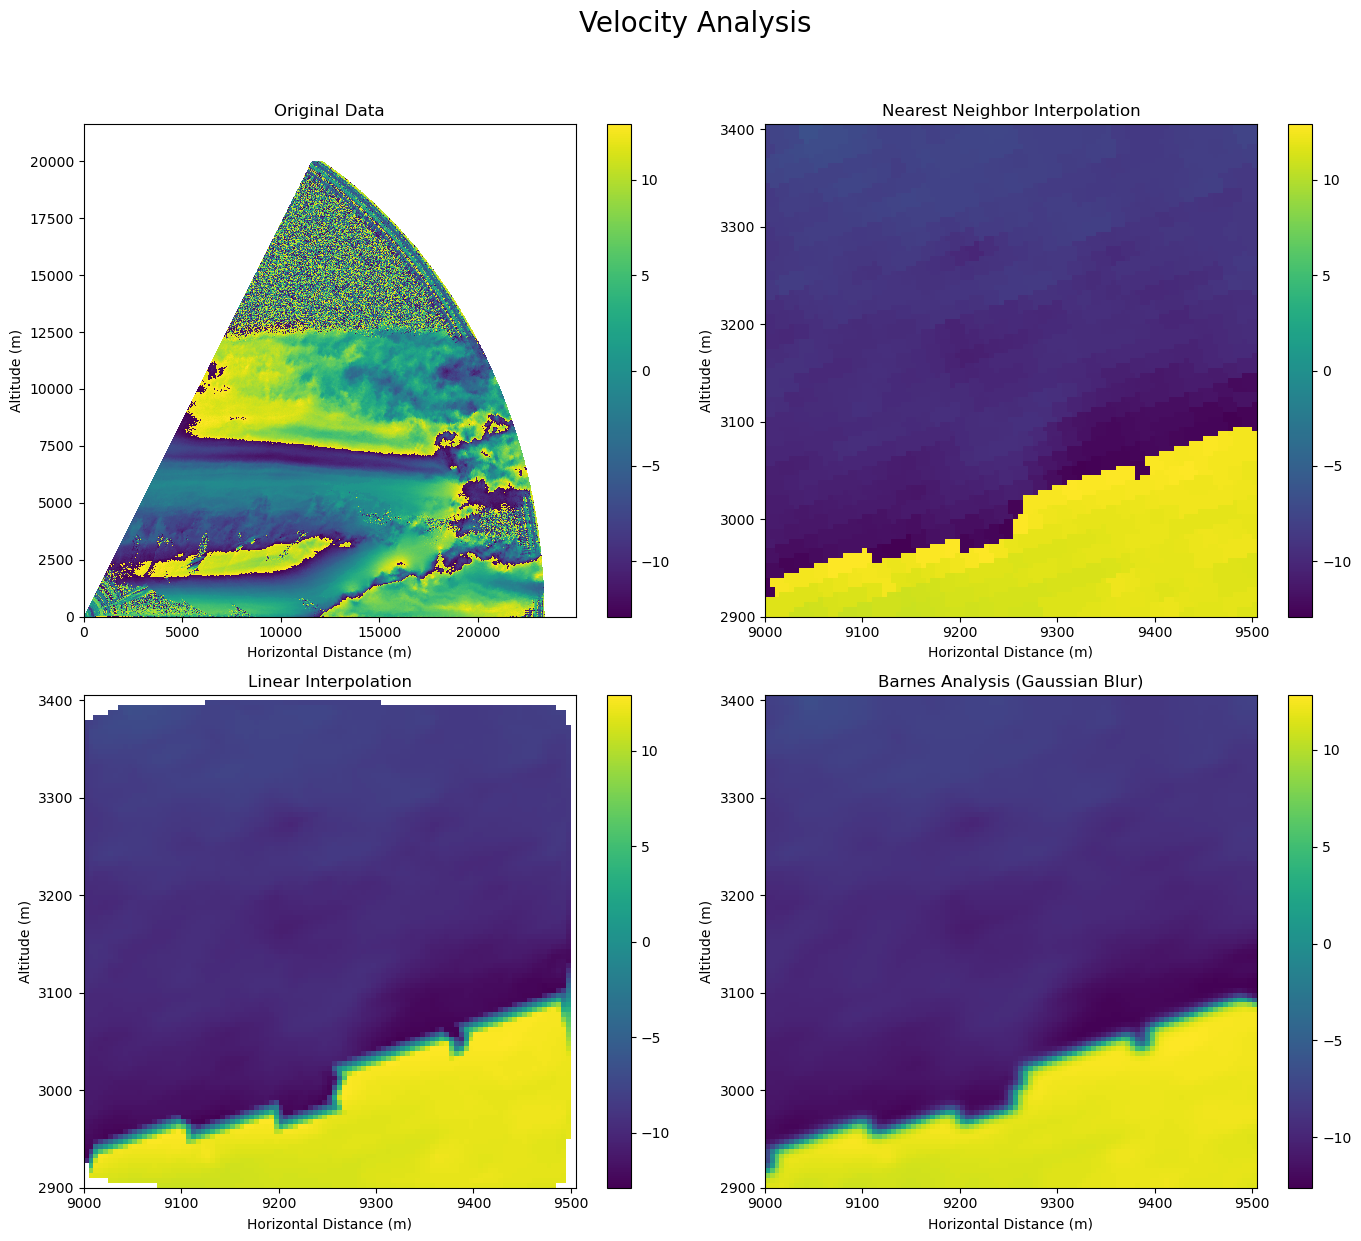

In [22]:
# 2.) Interpolation for Velocity

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

# Main Title for the Entire Figure
fig.suptitle('Velocity Analysis', fontsize=20, y=1.03)

# Plot Original Data
c1 = axes[0, 0].pcolormesh(x_vel, z_vel, vel, shading='auto', cmap='viridis')
axes[0, 0].set_title('Original Data')
axes[0, 0].set_xlabel('Horizontal Distance (m)')
axes[0, 0].set_ylabel('Altitude (m)')
fig.colorbar(c1, ax=axes[0, 0])

# Plot Nearest Neighbor Interpolation
c2 = axes[0, 1].pcolormesh(X_centers_grid, Y_centers_grid, nearest_interp_vel, shading='auto', cmap='viridis')
axes[0, 1].set_title('Nearest Neighbor Interpolation')
axes[0, 1].set_xlabel('Horizontal Distance (m)')
axes[0, 1].set_ylabel('Altitude (m)')
fig.colorbar(c2, ax=axes[0, 1])

# Plot Linear Interpolation
c3 = axes[1, 0].pcolormesh(X_centers_grid, Y_centers_grid, linear_interp_vel, shading='auto', cmap='viridis')
axes[1, 0].set_title('Linear Interpolation')
axes[1, 0].set_xlabel('Horizontal Distance (m)')
axes[1, 0].set_ylabel('Altitude (m)')
fig.colorbar(c3, ax=axes[1, 0])

# Plot Barnes Interpolation
c4 = axes[1, 1].pcolormesh(X_centers_grid, Y_centers_grid, barnes_interp_vel, shading='auto', cmap='viridis')
axes[1, 1].set_title('Barnes Analysis (Gaussian Blur)')
axes[1, 1].set_xlabel('Horizontal Distance (m)')
axes[1, 1].set_ylabel('Altitude (m)')
fig.colorbar(c4, ax=axes[1, 1])

# Adjust layout for clarity
plt.tight_layout()
plt.show()


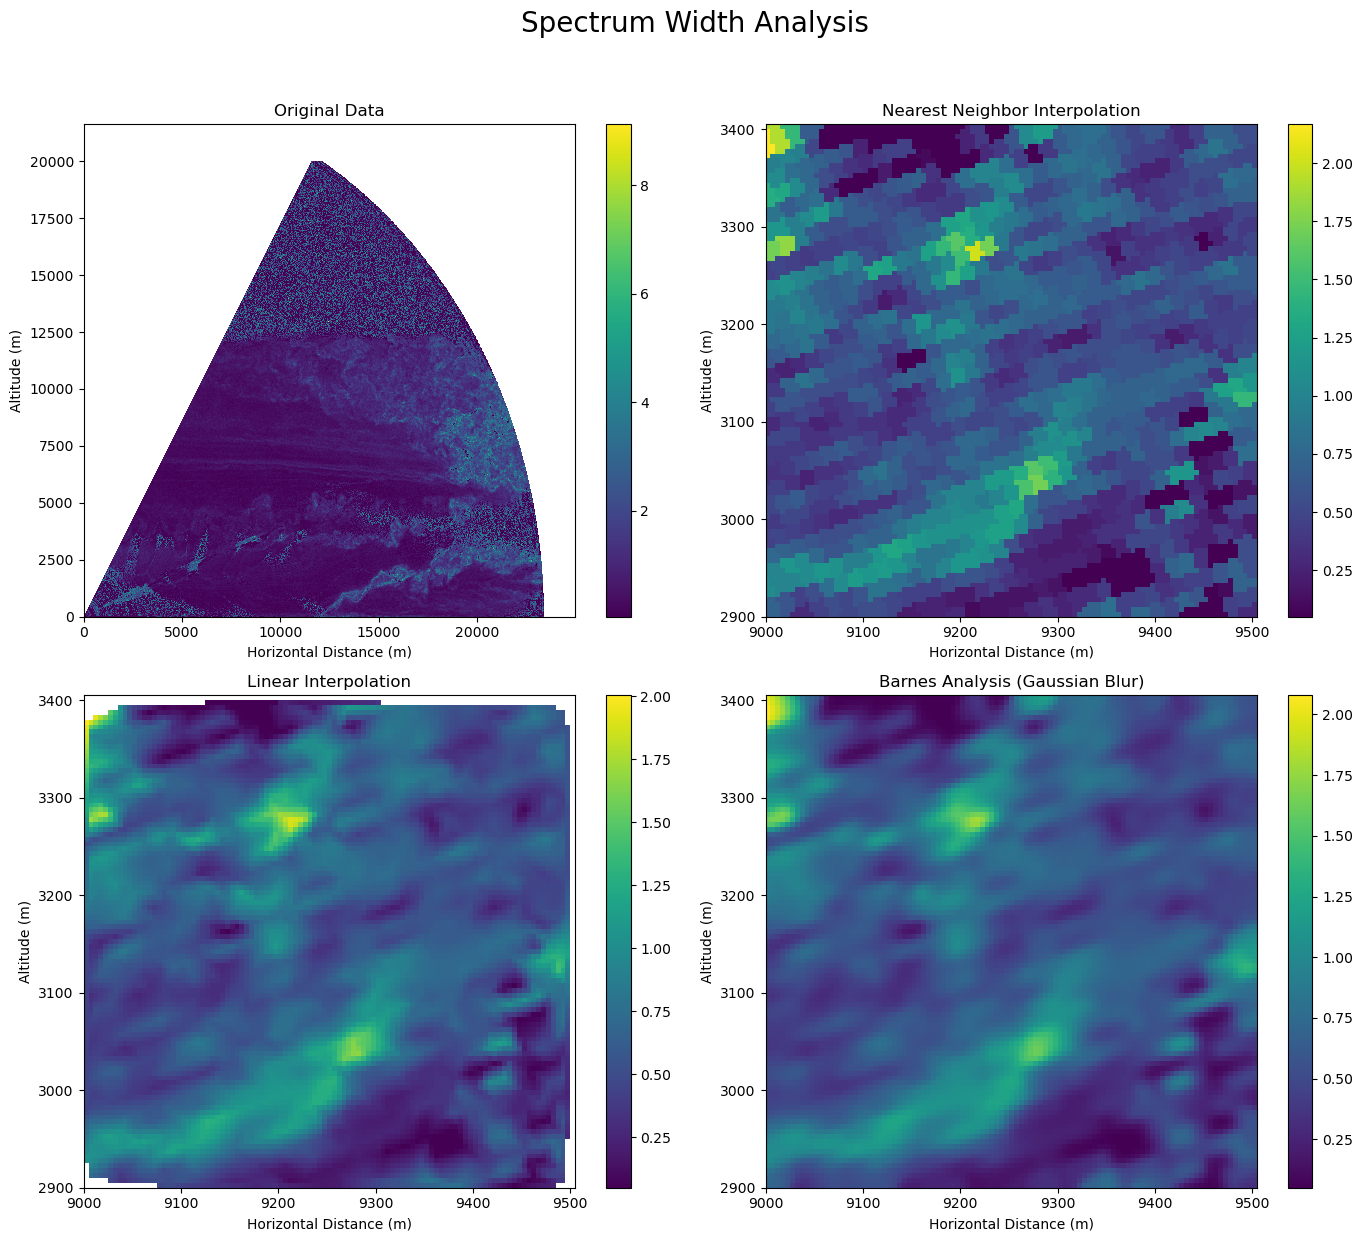

In [23]:
# 3.) Interpolation for Spectrum Width

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

# Main Title for the Entire Figure
fig.suptitle('Spectrum Width Analysis', fontsize=20, y=1.03)

# Plot Original Data
c1 = axes[0, 0].pcolormesh(x_sw, z_sw, sw, shading='auto', cmap='viridis')
axes[0, 0].set_title('Original Data')
axes[0, 0].set_xlabel('Horizontal Distance (m)')
axes[0, 0].set_ylabel('Altitude (m)')
fig.colorbar(c1, ax=axes[0, 0])

# Plot Nearest Neighbor Interpolation
c2 = axes[0, 1].pcolormesh(X_centers_grid, Y_centers_grid, nearest_interp_sw, shading='auto', cmap='viridis')
axes[0, 1].set_title('Nearest Neighbor Interpolation')
axes[0, 1].set_xlabel('Horizontal Distance (m)')
axes[0, 1].set_ylabel('Altitude (m)')
fig.colorbar(c2, ax=axes[0, 1])

# Plot Linear Interpolation
c3 = axes[1, 0].pcolormesh(X_centers_grid, Y_centers_grid, linear_interp_sw, shading='auto', cmap='viridis')
axes[1, 0].set_title('Linear Interpolation')
axes[1, 0].set_xlabel('Horizontal Distance (m)')
axes[1, 0].set_ylabel('Altitude (m)')
fig.colorbar(c3, ax=axes[1, 0])

# Plot Barnes Interpolation
c4 = axes[1, 1].pcolormesh(X_centers_grid, Y_centers_grid, barnes_interp_sw, shading='auto', cmap='viridis')
axes[1, 1].set_title('Barnes Analysis (Gaussian Blur)')
axes[1, 1].set_xlabel('Horizontal Distance (m)')
axes[1, 1].set_ylabel('Altitude (m)')
fig.colorbar(c4, ax=axes[1, 1])

# Adjust layout for clarity
plt.tight_layout()
plt.show()

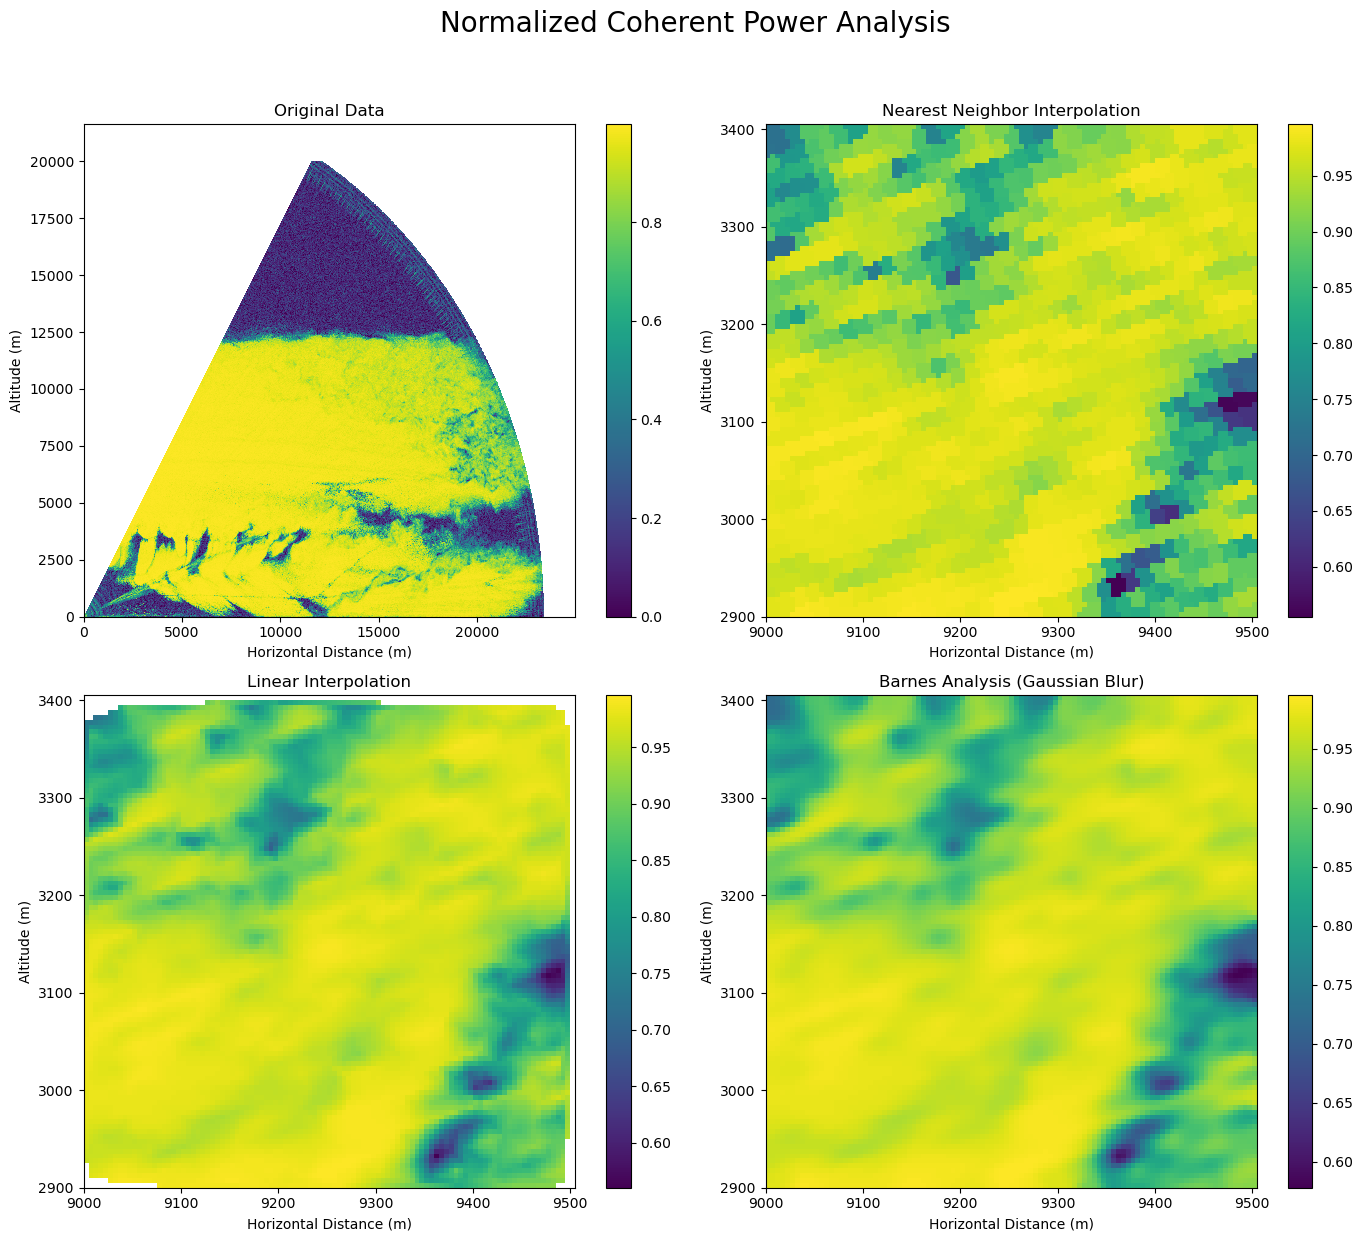

In [24]:
# 4.) Interpolation for Normalized Coherent Power

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

# Main Title for the Entire Figure
fig.suptitle('Normalized Coherent Power Analysis', fontsize=20, y=1.03)

# Plot Original Data
c1 = axes[0, 0].pcolormesh(x_ncp, z_ncp, ncp, shading='auto', cmap='viridis')
axes[0, 0].set_title('Original Data')
axes[0, 0].set_xlabel('Horizontal Distance (m)')
axes[0, 0].set_ylabel('Altitude (m)')
fig.colorbar(c1, ax=axes[0, 0])

# Plot Nearest Neighbor Interpolation
c2 = axes[0, 1].pcolormesh(X_centers_grid, Y_centers_grid, nearest_interp_ncp, shading='auto', cmap='viridis')
axes[0, 1].set_title('Nearest Neighbor Interpolation')
axes[0, 1].set_xlabel('Horizontal Distance (m)')
axes[0, 1].set_ylabel('Altitude (m)')
fig.colorbar(c2, ax=axes[0, 1])

# Plot Linear Interpolation
c3 = axes[1, 0].pcolormesh(X_centers_grid, Y_centers_grid, linear_interp_ncp, shading='auto', cmap='viridis')
axes[1, 0].set_title('Linear Interpolation')
axes[1, 0].set_xlabel('Horizontal Distance (m)')
axes[1, 0].set_ylabel('Altitude (m)')
fig.colorbar(c3, ax=axes[1, 0])

# Plot Barnes Interpolation
c4 = axes[1, 1].pcolormesh(X_centers_grid, Y_centers_grid, barnes_interp_ncp, shading='auto', cmap='viridis')
axes[1, 1].set_title('Barnes Analysis (Gaussian Blur)')
axes[1, 1].set_xlabel('Horizontal Distance (m)')
axes[1, 1].set_ylabel('Altitude (m)')
fig.colorbar(c4, ax=axes[1, 1])

# Adjust layout for clarity
plt.tight_layout()
plt.show()

#### Comparison between the original data and the interpolated data
For this instance, the effects of interpolation on reflectivity, velocity, spectrum width, and normalized coherent power are generally consistent and similar. They are described below:

#### Original Data:
- The original data clearly exhibits a more distinct and detailed spatial distribution of reflectivity, velocity, spectrum width, and normalized coherent power. Although, the presence of some noise or finer details can be observed. 

#### Nearest Neighbor Interpolation:
- The data seems blocky. Further studies shows that this is characteristic of nearest-neighbor interpolation as it assigns the nearest sample value to every point in a region. Some finer details from the original data are lost, particularly from the left bottom right-angle to the top upper right-angle (more pronnounced on the Normalized Coherent Power and Spectrum Width Analysis plots).

#### Linear Interpolation:
- It appears that linear interpolation provides smoother transitions between data points when compared to nearest-neighbor. Some of the finer details from the original data seems to be better preserved than with nearest-neighbor. In any case, I feel it may introduce some non-existing features (some sort of artifacts). 

#### Barnes Analysis (Gaussian Blur):
- The plots appear the smoothest among all methods. Finer details from the original data are blurred out. A little study reveals that, this blurry qualities can be desirable when we want to see the overall trend or when we want to reduce noise.


#### <u>Some desirable properties of an analysis.</u>
`Accuracy:` The results should closely represent the true state or value. Interpolation or any processing steps shouldn't introduce significant biases.

`Precision:` The results should be reproducible. Given the same input and conditions, the analysis method should produce the same or very similar outcomes.

`Transparency:` The analysis method should be well-documented and understandable. Other researchers or users should be able to replicate the results using the provided methods.

`Efficiency:` In terms of computational time and resources, the method should be optimized. This is especially important for large datasets or when real-time processing is required.

`Flexibility:` It should be adaptable to changes or variations in the data. For instance, if the dataset's size changes or if there are missing data points, the method should still function.

`Simplicity:` While complex methods can sometimes provide more accurate results, there's value in simplicity. A simpler method can often be more transparent, understandable, and less prone to overfitting.

`Consistency:` The method should produce consistent results across different datasets or under varying conditions.

`Scalability:` As datasets grow, the method should be capable of handling increased data volume without a significant drop in performance.

`Validation:` Any analytical method should have some form of validation, either through comparison with known results, cross-validation techniques, or other methods.

`Relevance:` The method should be suited for the specific type of data and the specific questions being asked.

`Ethical Considerations:` Especially in human-related studies, it's crucial that the analysis methods respect privacy and ethical guidelines.